# Setting Up & Imports

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

from ipywidgets import interact, FloatSlider, IntSlider

# Coin Toss Problem

In [2]:
def plot_beta(alpha, beta):
    dist = torch.distributions.Beta(concentration1=alpha, concentration0=beta)
    xs = torch.linspace(0, 1, 500)
    ys = dist.log_prob(xs).exp()
    plt.plot(xs, ys, color='C0')
    plt.grid()
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$p(\theta)$')
    plt.title('Beta Distribution')
    plt.show()
interact(plot_beta, alpha=FloatSlider(min=1, max=11, step=0.5, value=1), beta=FloatSlider(min=1, max=11, step=0.5, value=1))

interactive(children=(FloatSlider(value=1.0, description='alpha', max=11.0, min=1.0, step=0.5), FloatSlider(va…

<function __main__.plot_beta(alpha, beta)>

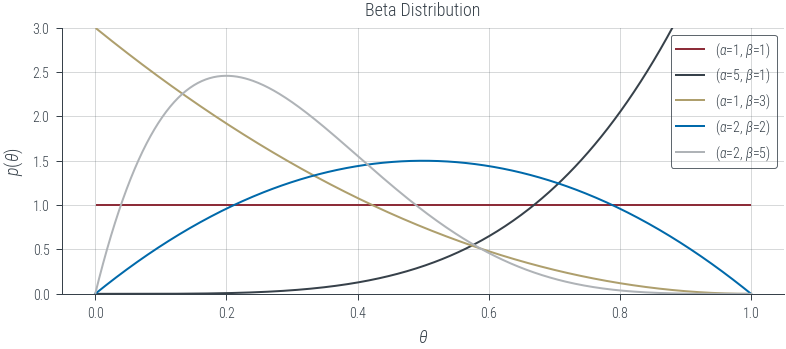

In [3]:
combinations = [
    [1, 1],
    [5, 1],
    [1, 3],
    [2, 2],
    [2, 5]
]
fig, ax = plt.subplots(1, 1)
for (alpha, beta) in combinations:
    dist = torch.distributions.Beta(concentration1=alpha, concentration0=beta)
    xs = torch.linspace(0, 1, 500)
    ys = dist.log_prob(xs).exp()
    ax.plot(xs, ys, label=rf'($\alpha$={alpha}, $\beta$={beta})')
ax.legend()
ax.grid()
ax.set_xlabel(r'$\theta$')
ax.set_ylabel(r'$p(\theta)$')
ax.set_title('Beta Distribution')
ax.set_ylim(0, 3)
plt.savefig('../figures/map/beta_distribution.pdf', bbox_inches='tight')
plt.show()


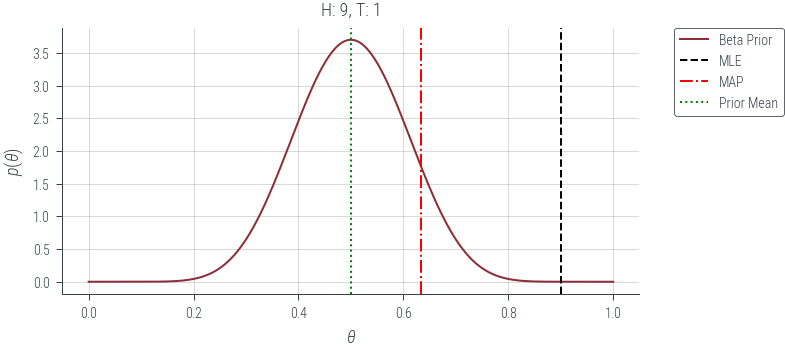

In [4]:
alpha = 11
beta = 11
bernoulli_theta = 0.5
n_1 = 9
n_0 = 1

dist = torch.distributions.Beta(concentration1=alpha, concentration0=beta)
xs = torch.linspace(0, 1, 500)
ys = dist.log_prob(xs).exp()
plt.plot(xs, ys, label='Beta Prior')

sample_size = n_1 + n_0
plt.title(f"H: {n_1}, T: {n_0}")

mle_estimate = n_1 / (sample_size)#samples.mean()
plt.axvline(mle_estimate, color='k', linestyle='--', label='MLE')

map_estimate = (n_1 + alpha - 1) / (sample_size + alpha + beta - 2)
plt.axvline(map_estimate, color='r', linestyle='-.', label='MAP')

plt.axvline(alpha / (alpha + beta), color='g', linestyle=':', label='Prior Mean')

plt.grid()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$p(\theta)$')
plt.legend(bbox_to_anchor=(1.25,1), borderaxespad=0)
plt.savefig('../figures/map/coin_toss_prior_mle_map.pdf', bbox_inches='tight')
plt.show()

In [5]:
def plot_beta_all(alpha, beta, bernoulli_theta = 0.5, sample_size=10):
    torch.manual_seed(42)

    dist = torch.distributions.Beta(concentration1=alpha, concentration0=beta)
    xs = torch.linspace(0, 1, 500)
    ys = dist.log_prob(xs).exp()
    plt.plot(xs, ys, label='Beta Prior')

    samples = torch.empty(sample_size)
    for s_num in range(sample_size):
        dist = torch.distributions.Bernoulli(probs=bernoulli_theta)
        samples[s_num] = dist.sample()
    n_1 = int(samples.sum())
    n_0 = int(sample_size - n_1)
    plt.title(f"H: {n_1}, T: {n_0}")

    mle_estimate = n_1 / (sample_size)#samples.mean()
    plt.axvline(mle_estimate, color='k', linestyle='--', label='MLE')

    map_estimate = (n_1 + alpha - 1) / (sample_size + alpha + beta - 2)
    plt.axvline(map_estimate, color='r', linestyle='-.', label='MAP')

    plt.axvline(alpha / (alpha + beta), color='g', linestyle=':', label='Prior Mean')

    plt.grid()
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$p(\theta)$')
    plt.legend(bbox_to_anchor=(1.25,1), borderaxespad=0)
    plt.show()

interact(
    plot_beta_all,
    alpha=FloatSlider(min=1, max=51, step=1, value=11),
    beta=FloatSlider(min=1, max=51, step=1, value=11),
    bernoulli_theta = FloatSlider(min=0, max=1, step=0.1, value=0.5),
    sample_size = IntSlider(min=10, max=1000, step=10, value=10),
    )

interactive(children=(FloatSlider(value=11.0, description='alpha', max=51.0, min=1.0, step=1.0), FloatSlider(v…

<function __main__.plot_beta_all(alpha, beta, bernoulli_theta=0.5, sample_size=10)>

# Linear Regression

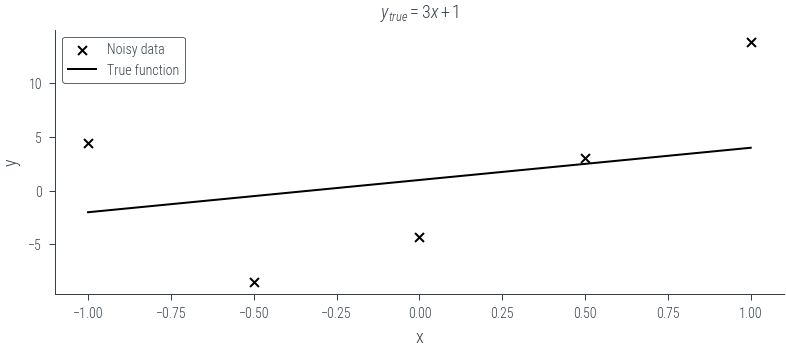

In [6]:
n_data = 5
x = torch.linspace(-1, 1, n_data)
f = lambda x: 3*x + 1

noise = torch.distributions.Normal(0, 5).sample((n_data,))
y = f(x) + noise

plt.figure()
plt.scatter(x, y, marker='x', c='k', s=20, label="Noisy data")
plt.plot(x, f(x), c='k', label="True function")
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$y_{true} = 3 x + 1$')
plt.savefig(f'../figures/map/linreg_data-{n_data}.pdf', bbox_inches='tight')
plt.legend()

In [8]:
def nll(theta):
    mu = theta[0] + theta[1] * x
    sigma = torch.tensor(1.0)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return -dist.log_prob(y).sum()

def neg_log_prior(theta):
    prior_mean = torch.tensor([0.0, 0.0])  # Prior mean for slope and intercept
    prior_std = torch.tensor([100, 100])    # Prior standard deviation for slope and intercept
    dist = torch.distributions.normal.Normal(prior_mean, prior_std)
    return -dist.log_prob(theta).sum()

def neg_log_joint(theta):
    return nll(theta) + neg_log_prior(theta)


In [9]:
# Create a grid of theta[0] and theta[1] values
theta0_values = torch.linspace(-4, 4, 100)
theta1_values = torch.linspace(-4, 4, 100)
theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
nll_values = torch.zeros_like(theta0_mesh)
nlp_values = torch.zeros_like(theta0_mesh)
nlj_values = torch.zeros_like(theta0_mesh)

for i in range(len(theta0_values)):
    for j in range(len(theta1_values)):
        theta_current = torch.tensor([theta0_values[i], theta1_values[j]])
        nll_values[i, j] = nll(theta_current)
        nlp_values[i, j] = neg_log_prior(theta_current)
        nlj_values[i, j] = neg_log_joint(theta_current)




/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


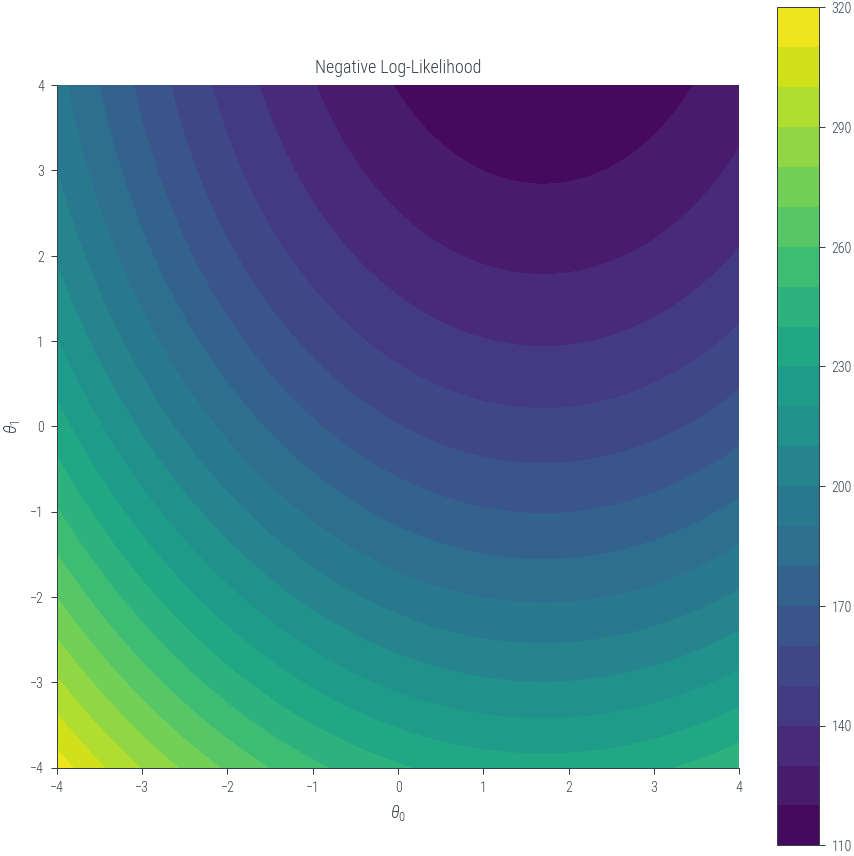

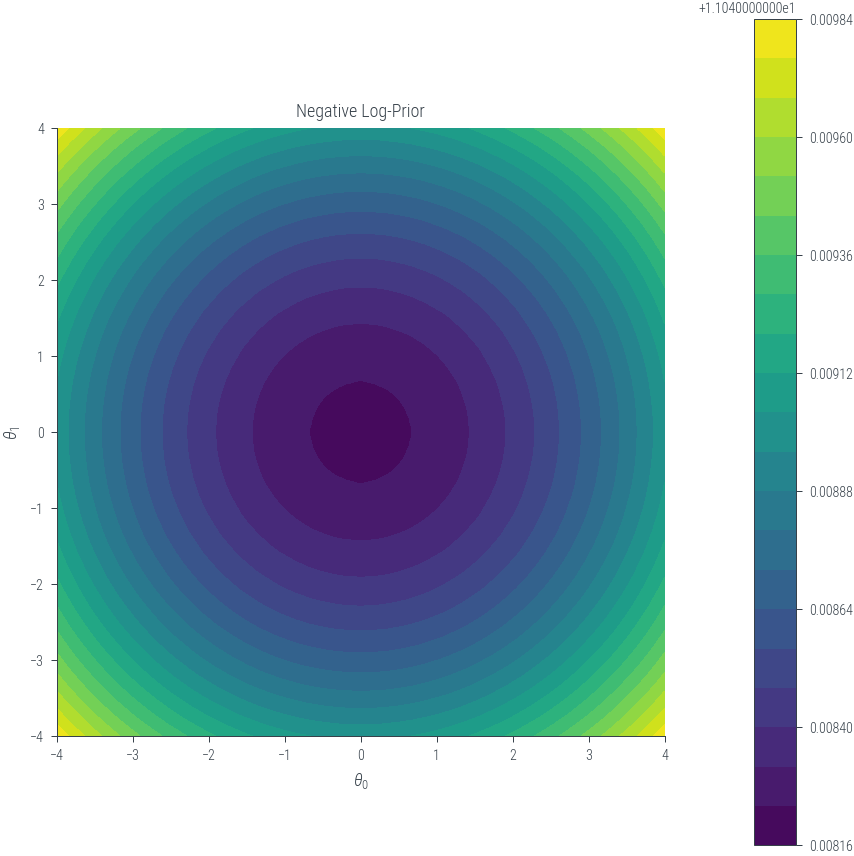

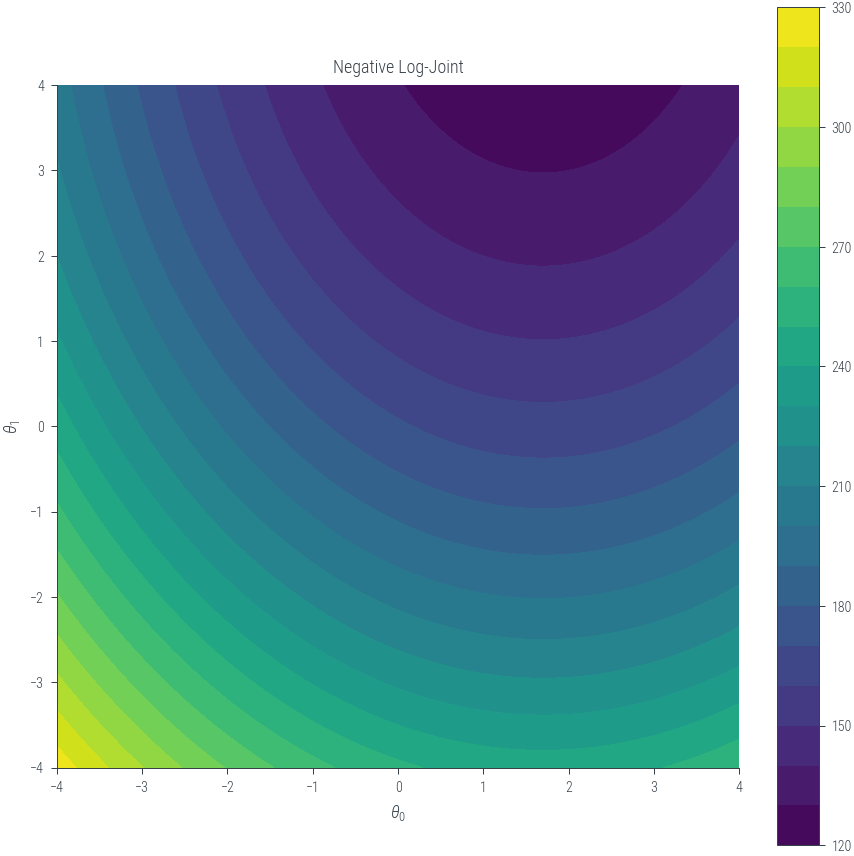

In [10]:

def plot_contour_with_minima(values, theta0_values, theta1_values, title):
    plt.figure(figsize=(6, 6))
    
    contour = plt.contourf(theta0_mesh, theta1_mesh, values, levels=20, cmap='viridis')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.title(title)
    
    plt.colorbar(contour)
    
    plt.gca().set_aspect('equal', adjustable='box')  # Set aspect ratio to be equal
    
    #plt.tight_layout()
    #plt.show()

# Usage example
plot_contour_with_minima(nll_values, theta0_values, theta1_values, 'Negative Log-Likelihood')
plot_contour_with_minima(nlp_values, theta0_values, theta1_values, 'Negative Log-Prior')
plot_contour_with_minima(nlj_values, theta0_values, theta1_values, 'Negative Log-Joint')


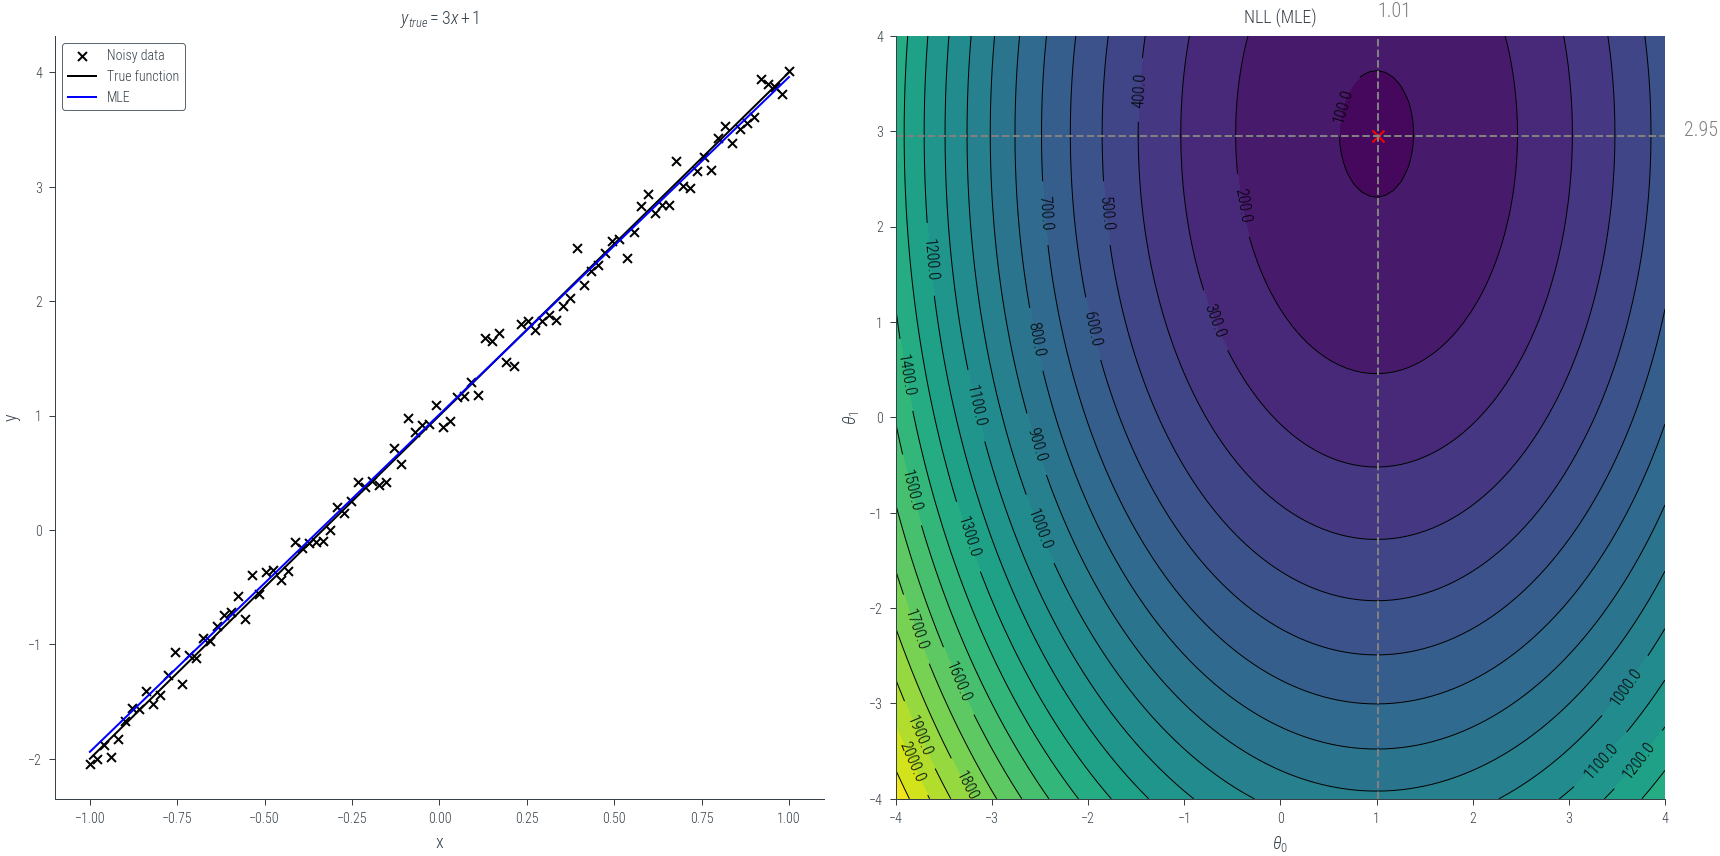

In [11]:
fig, ax = plt.subplots(1,2, figsize=(12, 6))

contour = ax[1].contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
# ax[1].colorbar(contour)
ax[1].set_xlabel(r'$\theta_0$')
ax[1].set_ylabel(r'$\theta_1$')
ax[1].set_title('NLL (MLE)')

# Adding contour level labels
contour_labels = ax[1].contour(theta0_mesh, theta1_mesh, nll_values, levels=20, colors='black', linewidths=0.5)
ax[1].clabel(contour_labels, inline=True, fontsize=8, fmt='%1.1f')

# Find and mark the minimum
min_indices = torch.argmin(nll_values)
min_theta0 = theta0_mesh.flatten()[min_indices]
min_theta1 = theta1_mesh.flatten()[min_indices]
ax[1].scatter(min_theta0, min_theta1, color='red', marker='x', label='Minima')

# Draw lines from the minimum point to the axes
ax[1].axhline(min_theta1, color='gray', linestyle='--')
ax[1].axvline(min_theta0, color='gray', linestyle='--')

# Add labels to the lines
ax[1].text(min_theta0, 4.2, f'{min_theta0:.2f}', color='gray', fontsize=10)
ax[1].text(4.2, min_theta1, f'{min_theta1:.2f}', color='gray', fontsize=10)
# ax[1].legend(bbox_to_anchor=(0, 1.05), loc='lower left')

ax[0].scatter(x, y, marker='x', c='k', s=20, label="Noisy data")
ax[0].plot(x, f(x), c='k', label="True function")
ax[0].plot(x, min_theta0 + min_theta1*x, c = 'b', label="MLE")
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].set_title(r'$y_{true} = 3 x + 1$')
ax[0].legend()
plt.savefig('../figures/map/linreg_mle.pdf', bbox_inches='tight')
plt.show()

In [7]:
# Create a grid of theta[0] and theta[1] values
theta0_values = torch.linspace(-4, 4, 100)
theta1_values = torch.linspace(-4, 4, 100)
theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
nll_values = torch.zeros_like(theta0_mesh)

# Calculate negative log-likelihood values for each combination of theta[0] and theta[1]
for i in range(len(theta0_values)):
    for j in range(len(theta1_values)):
        nll_values[i, j] = nll_with_prior([theta0_values[i], theta1_values[j]])

# Create a contour plot
plt.figure()#figsize=(8, 6))
contour = plt.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
# plt.colorbar(contour)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
#plt.title('Contour Plot of Negative Log-Likelihood')

# Adding contour level labels
contour_labels = plt.contour(theta0_mesh, theta1_mesh, nll_values, levels=20, colors='black', linewidths=0.5)
plt.clabel(contour_labels, inline=True, fontsize=8, fmt='%1.1f')

# Find and mark the minimum
min_indices = torch.argmin(nll_values)
min_theta0 = theta0_mesh.flatten()[min_indices]
min_theta1 = theta1_mesh.flatten()[min_indices]
plt.scatter(min_theta0, min_theta1, color='red', marker='x', label='Minima')

# Draw lines from the minimum point to the axes
plt.axhline(min_theta1, color='gray', linestyle='--')
plt.axvline(min_theta0, color='gray', linestyle='--')

# Add labels to the lines
plt.text(min_theta0, 4.2, f'{min_theta0:.2f}', color='gray', fontsize=10)
plt.text(4.2, min_theta1, f'{min_theta1:.2f}', color='gray', fontsize=10)
plt.legend(bbox_to_anchor=(0, 1.05), loc='lower left')

/home/nipun.batra/miniforge3/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


NameError: name 'nll_with_prior' is not defined

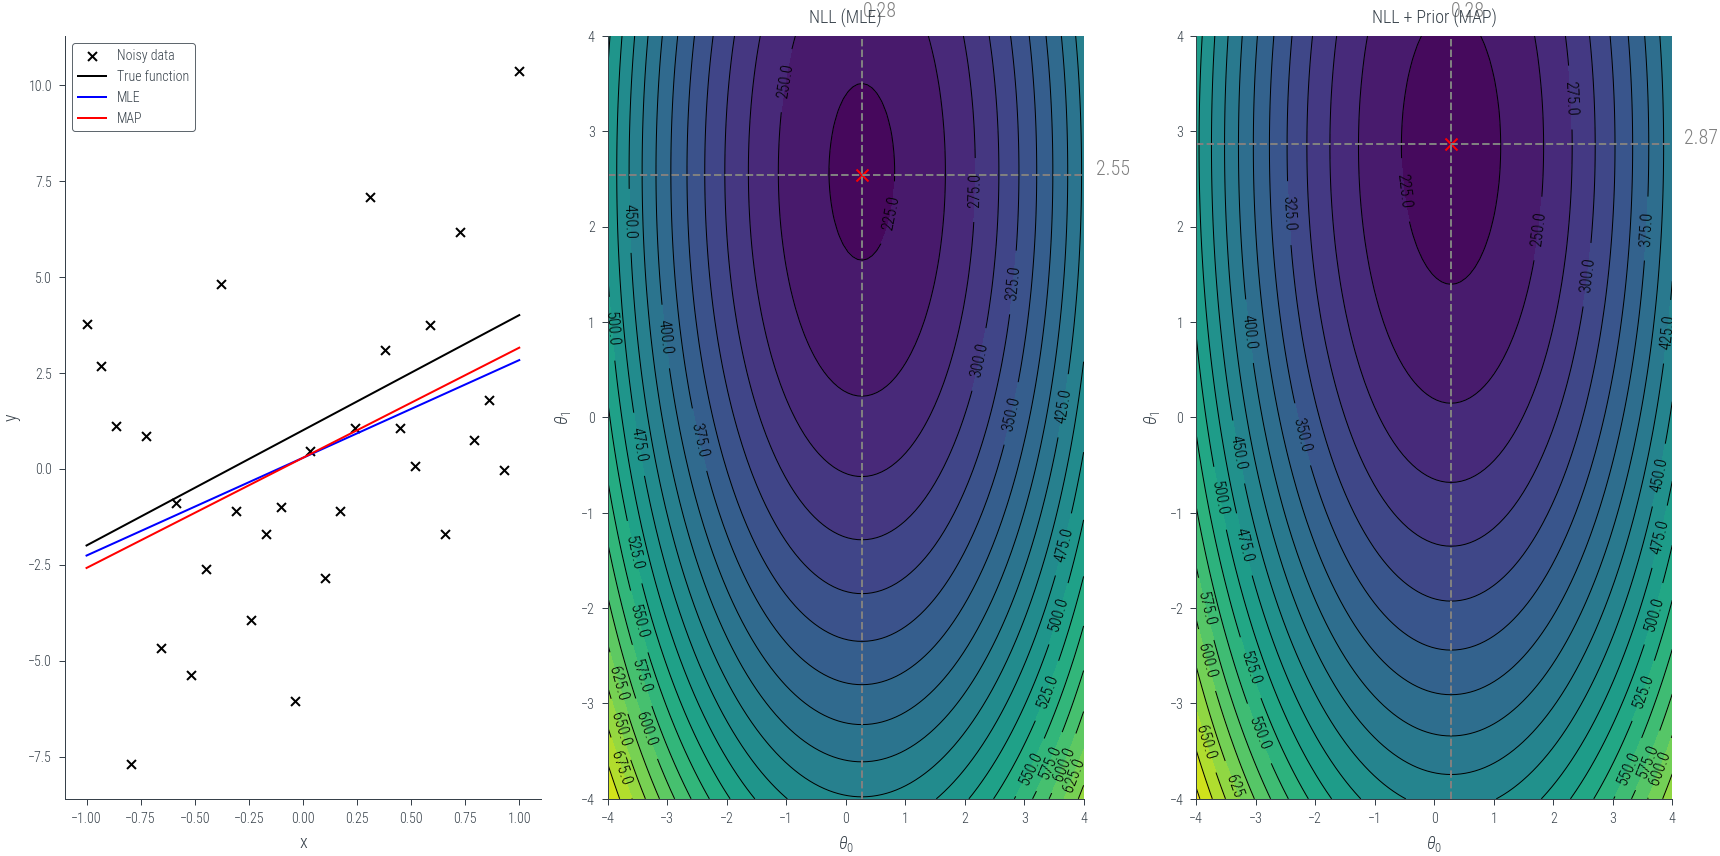

In [13]:
def lin_reg_map(noise_std, prior_std_lambda, n_samples):
    torch.manual_seed(42)

    x = torch.linspace(-1, 1, n_samples)
    f = lambda x: 3*x + 1

    noise = torch.distributions.Normal(0, noise_std).sample((n_samples,))
    y = f(x) + noise

    def nll(theta):
        mu = theta[0] + theta[1] * x
        sigma = torch.tensor(1.0)
        dist = torch.distributions.normal.Normal(mu, sigma)
        return -dist.log_prob(y).sum()

    def nll_with_prior(theta):
        theta = torch.tensor(theta)
        mu = theta[0] + theta[1] * x
        sigma_likelihood = torch.tensor(1.0)
        dist_likelihood = torch.distributions.normal.Normal(mu, sigma_likelihood)

        prior_mean = torch.tensor([0.0, 0.0])  # Prior mean for slope and intercept
        prior_std = torch.tensor([prior_std_lambda, prior_std_lambda])    # Prior standard deviation for slope and intercept
        dist_prior = torch.distributions.normal.Normal(prior_mean, prior_std)

        nll_likelihood = -dist_likelihood.log_prob(y).sum()
        log_prior = dist_prior.log_prob(theta).sum()

        return nll_likelihood + log_prior

    fig, ax = plt.subplots(1,3, figsize=(12, 6))
    ax[0].scatter(x, y, marker='x', c='k', s=20, label="Noisy data")
    ax[0].plot(x, f(x), c='k', label="True function")

    def plot_theta_contour(ax, func, title):
        # Create a grid of theta[0] and theta[1] values
        theta0_values = torch.linspace(-4, 4, 100)
        theta1_values = torch.linspace(-4, 4, 100)
        theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
        nll_values = torch.zeros_like(theta0_mesh)

        # Calculate negative log-likelihood values for each combination of theta[0] and theta[1]
        for i in range(len(theta0_values)):
            for j in range(len(theta1_values)):
                nll_values[i, j] = func([theta0_values[i], theta1_values[j]])

        # Create a contour plot
        contour = ax.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
        # plt.colorbar(contour)
        ax.set_xlabel(r'$\theta_0$')
        ax.set_ylabel(r'$\theta_1$')
        ax.set_title(title)

        # Adding contour level labels
        contour_labels = ax.contour(theta0_mesh, theta1_mesh, nll_values, levels=20, colors='black', linewidths=0.5)
        ax.clabel(contour_labels, inline=True, fontsize=8, fmt='%1.1f')

        # Find and mark the minimum
        min_indices = torch.argmin(nll_values)
        min_theta0 = theta0_mesh.flatten()[min_indices]
        min_theta1 = theta1_mesh.flatten()[min_indices]
        ax.scatter(min_theta0, min_theta1, color='red', marker='x', label='Minima')

        # Draw lines from the minimum point to the axes
        ax.axhline(min_theta1, color='gray', linestyle='--')
        ax.axvline(min_theta0, color='gray', linestyle='--')

        # Add labels to the lines
        ax.text(min_theta0, 4.2, f'{min_theta0:.2f}', color='gray', fontsize=10)
        ax.text(4.2, min_theta1, f'{min_theta1:.2f}', color='gray', fontsize=10)
        # ax.legend(bbox_to_anchor=(0, -0.05), loc='lower left')
        return min_theta0, min_theta1

    mle_theta0, mle_theta1 = plot_theta_contour(ax[1], nll, 'NLL (MLE)')

    map_theta0, map_theta1 = plot_theta_contour(ax[2], nll_with_prior, 'NLL + Prior (MAP)')

    ax[0].plot(x, mle_theta0 + mle_theta1*x, c='b', label="MLE")
    ax[0].plot(x, map_theta0 + map_theta1*x, c='r', label="MAP")
    ax[0].legend()
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    # ax[0].set_title(r'$y_{true} = 3 x + 1$')
    plt.savefig('../figures/map/linreg_mle_map.pdf', bbox_inches='tight')
    plt.show()

lin_reg_map(noise_std = 3.0, prior_std_lambda = 1.0, n_samples = 30)

In [14]:
interact(
    lin_reg_map,
    noise_std = FloatSlider(min=0.1, max=3.0, step=0.1, value=0.1),
    prior_std_lambda = FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0),
    n_samples = IntSlider(min=10, max=1000, step=10, value=100)
    )

interactive(children=(FloatSlider(value=0.1, description='noise_std', max=3.0, min=0.1), FloatSlider(value=1.0…

<function __main__.lin_reg_map(noise_std, prior_std_lambda, n_samples)>

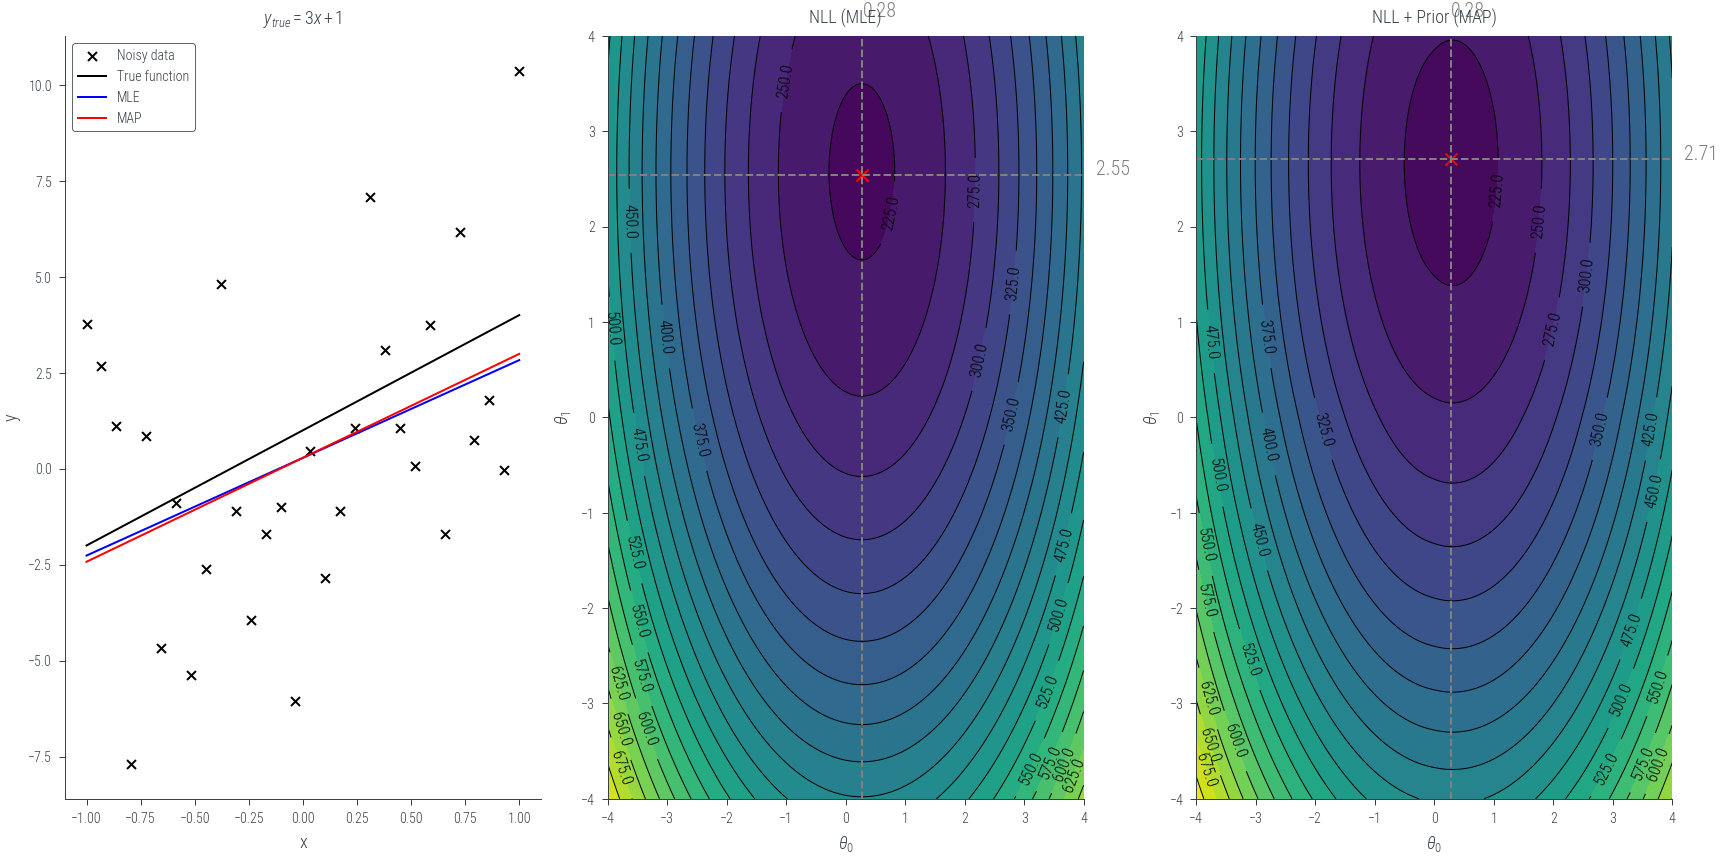

In [15]:
def lin_reg_map_laplace(noise_std, prior_std_lambda, n_samples):
    torch.manual_seed(42)

    x = torch.linspace(-1, 1, n_samples)
    f = lambda x: 3*x + 1

    noise = torch.distributions.Normal(0, noise_std).sample((n_samples,))
    y = f(x) + noise

    def nll(theta):
        mu = theta[0] + theta[1] * x
        sigma = torch.tensor(1.0)
        dist = torch.distributions.normal.Normal(mu, sigma)
        return -dist.log_prob(y).sum()

    def nll_with_prior(theta):
        theta = torch.tensor(theta)
        mu = theta[0] + theta[1] * x
        sigma_likelihood = torch.tensor(1.0)
        dist_likelihood = torch.distributions.normal.Normal(mu, sigma_likelihood)

        prior_mean = torch.tensor([0.0, 0.0])  # Prior mean for slope and intercept
        prior_std = torch.tensor([prior_std_lambda, prior_std_lambda])    # Prior standard deviation for slope and intercept
        dist_prior = torch.distributions.normal.Normal(prior_mean, prior_std)

        nll_likelihood = -dist_likelihood.log_prob(y).sum()
        log_prior = dist_prior.log_prob(theta).sum()

        return nll_likelihood + log_prior

    def nll_with_laplace_prior(theta):
        theta = torch.tensor(theta)
        mu = theta[0] + theta[1] * x
        sigma_likelihood = torch.tensor(1.0)
        dist_likelihood = torch.distributions.normal.Normal(mu, sigma_likelihood)

        prior_mean = torch.tensor([0.0, 0.0])  # Prior mean for slope and intercept
        prior_std = torch.tensor([prior_std_lambda, prior_std_lambda])     # Prior standard deviation for slope and intercept
        dist_prior = torch.distributions.laplace.Laplace(prior_mean, prior_std)

        nll_likelihood = -dist_likelihood.log_prob(y).sum()
        log_prior = dist_prior.log_prob(theta).sum()

        return nll_likelihood + log_prior

    fig, ax = plt.subplots(1,3, figsize=(12, 6))
    ax[0].scatter(x, y, marker='x', c='k', s=20, label="Noisy data")
    ax[0].plot(x, f(x), c='k', label="True function")

    def plot_theta_contour(ax, func, title):
        # Create a grid of theta[0] and theta[1] values
        theta0_values = torch.linspace(-4, 4, 100)
        theta1_values = torch.linspace(-4, 4, 100)
        theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
        nll_values = torch.zeros_like(theta0_mesh)

        # Calculate negative log-likelihood values for each combination of theta[0] and theta[1]
        for i in range(len(theta0_values)):
            for j in range(len(theta1_values)):
                nll_values[i, j] = func([theta0_values[i], theta1_values[j]])

        # Create a contour plot
        contour = ax.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
        # plt.colorbar(contour)
        ax.set_xlabel(r'$\theta_0$')
        ax.set_ylabel(r'$\theta_1$')
        ax.set_title(title)

        # Adding contour level labels
        contour_labels = ax.contour(theta0_mesh, theta1_mesh, nll_values, levels=20, colors='black', linewidths=0.5)
        ax.clabel(contour_labels, inline=True, fontsize=8, fmt='%1.1f')

        # Find and mark the minimum
        min_indices = torch.argmin(nll_values)
        min_theta0 = theta0_mesh.flatten()[min_indices]
        min_theta1 = theta1_mesh.flatten()[min_indices]
        ax.scatter(min_theta0, min_theta1, color='red', marker='x', label='Minima')

        # Draw lines from the minimum point to the axes
        ax.axhline(min_theta1, color='gray', linestyle='--')
        ax.axvline(min_theta0, color='gray', linestyle='--')

        # Add labels to the lines
        ax.text(min_theta0, 4.2, f'{min_theta0:.2f}', color='gray', fontsize=10)
        ax.text(4.2, min_theta1, f'{min_theta1:.2f}', color='gray', fontsize=10)
        # ax.legend(bbox_to_anchor=(0, -0.05), loc='lower left')
        return min_theta0, min_theta1

    mle_theta0, mle_theta1 = plot_theta_contour(ax[1], nll, 'NLL (MLE)')

    # map_theta0, map_theta1 = plot_theta_contour(ax[2], nll_with_prior, 'NLL + Prior (MAP)')
    map_theta0, map_theta1 = plot_theta_contour(ax[2], nll_with_laplace_prior, 'NLL + Prior (MAP)')

    ax[0].plot(x, mle_theta0 + mle_theta1*x, c='b', label="MLE")
    ax[0].plot(x, map_theta0 + map_theta1*x, c='r', label="MAP")
    ax[0].legend()
    ax[0].set_xlabel('x')
    ax[0].set_ylabel('y')
    ax[0].set_title(r'$y_{true} = 3 x + 1$')
    plt.savefig('../figures/map/linreg_mle_map_laplace.pdf', bbox_inches='tight')
    plt.show()

lin_reg_map_laplace(noise_std = 3.0, prior_std_lambda = 1.0, n_samples = 30)